In [130]:
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Splitting folder into train, test, val folder

In [110]:
import splitfolders

input_folder = "pisang" #Enter Input Folder
output = "dataset" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7,0.2,0.1))

Copying files: 1002 files [00:04, 227.41 files/s]


#### Check image shape

In [111]:
imgs = cv2.imread("dataset/train/pisang-kulit-luka/IMG_0003.jpg")

In [112]:
imgs.shape

(72, 128, 3)

### Data augmentation

In [113]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rotation_range = 40,
    width_shift_range= 0.2,
    height_shift_range= 0.2
)

validate_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [116]:
train_data =  train_datagen.flow_from_directory(
        "dataset/train",
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical')

validate_data = validate_datagen.flow_from_directory(
        "dataset/val",
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical')

test_data =  test_datagen.flow_from_directory(
        "dataset/test",
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical')

Found 700 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [117]:
num_class = test_data.num_classes
labels = train_data.class_indices.keys()

In [120]:
print(num_class)
print(labels)

2
dict_keys(['pisang-kulit-luka', 'pisang-kulit-tidak-luka'])


### Building Model

In [136]:
model = Sequential()
model.add(Conv2D(filters=32,activation='relu',kernel_size=5,input_shape=[150,150,3]))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Conv2D(filters=64,activation='relu',kernel_size=3))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Conv2D(filters=96,activation='relu',kernel_size=3))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Conv2D(filters=96,activation='relu',kernel_size=3))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Flatten())

model.add(Dense(64,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 96)      

In [137]:
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [140]:
model.fit(train_data,
          verbose=1,
          validation_data=validate_data,
          batch_size=64,
          epochs=50,
          callbacks=[es])

Epoch 1/50
22/22 [==============================] - 4s 185ms/step - loss: 0.6123 - accuracy: 0.7086 - val_loss: 0.5639 - val_accuracy: 0.7100
Epoch 2/50
22/22 [==============================] - 4s 184ms/step - loss: 0.5354 - accuracy: 0.7314 - val_loss: 0.4882 - val_accuracy: 0.7600
Epoch 3/50
22/22 [==============================] - 4s 194ms/step - loss: 0.4728 - accuracy: 0.7743 - val_loss: 0.4486 - val_accuracy: 0.7800
Epoch 4/50
22/22 [==============================] - 5s 203ms/step - loss: 0.4605 - accuracy: 0.7743 - val_loss: 0.4308 - val_accuracy: 0.8000
Epoch 5/50
22/22 [==============================] - 6s 277ms/step - loss: 0.4166 - accuracy: 0.8100 - val_loss: 0.4451 - val_accuracy: 0.7950
Epoch 6/50
22/22 [==============================] - 7s 333ms/step - loss: 0.3982 - accuracy: 0.8329 - val_loss: 0.4251 - val_accuracy: 0.8100
Epoch 7/50
22/22 [==============================] - 5s 233ms/step - loss: 0.3432 - accuracy: 0.8586 - val_loss: 0.3541 - val_accuracy: 0.8550
Epoch 

### Creating dataframe of losses and accuracies of model

In [141]:
losses = model.history.history
df_loss = pd.DataFrame(losses)

In [142]:
df_loss.sort_values(by='val_accuracy',ascending=False).head()

,loss,accuracy,val_loss,val_accuracy
15,0.316238,0.877143,0.255619,0.905
16,0.232156,0.925714,0.268402,0.890
9,0.331239,0.870000,0.319066,0.870
12,0.289092,0.888571,0.286240,0.870
17,0.235352,0.908571,0.329287,0.865


Text(0, 0.5, 'Accuracy')

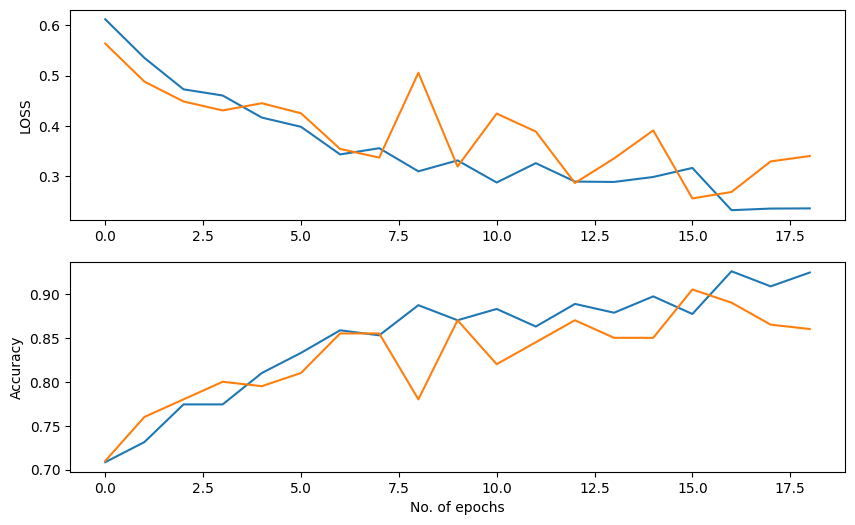

In [143]:
fig,axes = plt.subplots(2,1,figsize=(10,6))
axes[0].plot(df_loss[['loss','val_loss']])
axes[0].set_ylabel("LOSS")

axes[1].plot(df_loss[['accuracy','val_accuracy']])
axes[1].set_xlabel("No. of epochs")
axes[1].set_ylabel("Accuracy")

In [147]:
loss, accuracy= model.evaluate(test_data)
print(f'Accuracy: {accuracy*100}')

4/4 [==============================] - 1s 230ms/step - loss: 0.3898 - accuracy: 0.8627
Accuracy: 86.27451062202454


### Predict

1/1 [==============================] - 0s 25ms/step
prediksi: Pisang Kulit Luka
persentase prediksi: 98.77 %


prediksi:	Pisang Kulit Luka
persentase:	98.77 %
prediksi:	Pisang Kulit Tidak Luka
persentase:	1.23 %


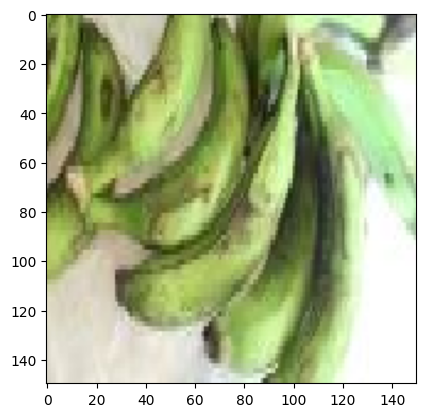

In [152]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_names =  ["Pisang Kulit Luka", "Pisang Kulit Tidak Luka"]

image_path = "dataset/test/pisang-kulit-luka/IMG_0073.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)/255
img = np.expand_dims(img, axis=0)

images = np.vstack([img])

prediction = model.predict(images, batch_size=10)
predictions = np.argmax(prediction,axis=1)

print('prediksi: {}'.format(class_names[predictions[0]]))
print('persentase prediksi: {:.2f} %'.format(np.max(prediction)*100))
print('\n')
for i in range(len(class_names)):
    print('prediksi:\t{}'. format(class_names[i]))
    print("persentase:\t{:.2f} %".format(prediction[0][i]*100))

plt.imshow(new_img)